# Build an agent with tool-calling superpowers 🦸 using smolagents
_Authored by: [Aymeric Roucher](https://huggingface.co/m-ric)_

This notebook demonstrates how you can use [**smolagents**](https://huggingface.co/docs/smolagents/index) to build awesome **agents**!

What are **agents**? Agents are systems that are powered by an LLM and enable the LLM (with careful prompting and output parsing) to use specific *tools* to solve problems.

These *tools* are basically functions that the LLM couldn't perform well by itself: for instance for a text-generation LLM like [Llama-3-70B](https://huggingface.co/meta-llama/Meta-Llama-3-70B-Instruct), this could be an image generation tool, a web search tool, a calculator...

What is **smolagents**? It's an library that provides building blocks to build your own agents! Learn more about it in the [documentation](https://huggingface.co/docs/smolagents/index).

Let's see how to use it, and which use cases it can solve.

Run the line below to install required dependencies:

In [ ]:
!pip install smolagents datasets langchain sentence-transformers faiss-cpu duckduckgo-search openai langchain-community --upgrade -q

Let's login in order to call the HF Inference API:

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## 1. 🏞️ Multimodal + 🌐 Web-browsing assistant

For this use case, we want to show an agent that browses the web and is able to generate images.

To build it, we simply need to have two tools ready: image generation and web search.
- For image generation, we load a tool from the Hub that uses the HF Inference API (Serverless) to generate images using Stable Diffusion.
- For the web search, we use a built-in tool.

TOOLCODE:
 from smolagents import Tool
from huggingface_hub import InferenceClient


class TextToImageTool(Tool):
    description = "This tool creates an image according to a prompt, which is a text description."
    name = "image_generator"
    inputs = {"prompt": {"type": "string", "description": "The image generator prompt. Don't hesitate to add details in the prompt to make the image look better, like 'high-res, photorealistic', etc."}}
    output_type = "image"
    model_sdxl = "black-forest-labs/FLUX.1-schnell"
    client = InferenceClient(model_sdxl)


    def forward(self, prompt):
        return self.client.text_to_image(prompt)



╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Generate me a photo of the car that James bond drove in the latest movie.                                       │
│                                                                                                                 │
╰─ HfApiModel - Qwen/Qwen2.5-72B-Instruct ────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 0 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭─ Executing this code: ──────────────────────────────────────────────────────────────────────────────────────────╮
│   1 search_query = "latest James Bond movie"                                                                    │
│   2 result = web_search(query=search_query)                                                                     │
│   3 print(result)                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Execution logs:
## Search Results

[James Bond 26 Casting Update Reveals Conditions For New 007: "It's A 
...](https://screenrant.com/james-bond-26-casting-conditions-updated-barbara-broccoli/)
James Bond 26 gets an intriguing new update from franchise producer Barbara Broccoli, who reveals the conditions 
for the next actor. After first playing the character in 2006's Casino Royale, Daniel Craig bid farewell to the hit
spy franchise with No Time To Die in 2021. There's been no actor officially cast as his replacement since, but the 
Internet and social media are awash with rumors and ...

[No Time to Die - Wikipedia](https://en.wikipedia.org/wiki/No_Time_to_Die)
No Time to Die is a 2021 spy film and the twenty-fifth in the James Bond series produced by Eon Productions, 
starring Daniel Craig in his final portrayal of fictional British MI6 agent James Bond.The plot follows Bond, who 
has left active service with MI6, and is recruited by the CIA to find a kidnapped scientist, which leads to a 
showdown with a powerful and vengeful adversary armed with a ...

[List of James Bond films - Wikipedia](https://en.wikipedia.org/wiki/List_of_James_Bond_films)
Find out the history, actors, directors, box office and budget of the James Bond film series. The latest film, No 
Time to Die, was released in September 2021 and starred Daniel Craig as 007.

[No Time to Die (2021) - IMDb](https://www.imdb.com/title/tt2382320/)
No Time to Die: Directed by Cary Joji Fukunaga. With Daniel Craig, Léa Seydoux, Rami Malek, Lashana Lynch. James 
Bond has left active service. His peace is short-lived when Felix Leiter, an old friend from the CIA, turns up 
asking for help, leading Bond onto the trail of a mysterious villain armed with dangerous new technology.

[Bond 26: Everything We Know About Next 007 Film - 
Newsweek](https://www.newsweek.com/james-bond-26-everything-we-know-next-007-film-1891233)
The James Bond films have been popular for decades and since Daniel Craig stepped away from the titular role in 
2021, people have been speculating what the future of the franchise will look like.

[No Time to Die (2021) - Rotten Tomatoes](https://www.rottentomatoes.com/m/no_time_to_die_2021)
Watch the trailer, read critics and audience reviews, and see the official clips of the latest James Bond film. No 
Time to Die is a long and action-packed adventure that concludes Craig's tenure as 007 with style and emotion.

[Next James Bond: everything we know so far about who will be the new 
...](https://www.timeout.com/news/everything-we-know-about-bond-26-so-far-010523)
The 26th instalment of the James Bond franchise is expected to be released in 2025, but the identity of the new 007
is still a mystery. Find out the latest rumours, odds and contenders for the role, from Aaron Taylor-Johnson to Tom
Hardy.

[When will the new James Bond be announced? Everything we know ... - 
Yahoo](https://www.yahoo.com/entertainment/james-bond-26-007-cast-rumours-release-date-143855208.html)
The James Bond movies celebrated their 60th anniversary in 2022. Now, in 2024, fans are eagerly anticipating the 
announcement of the new James Bond, and details of the next movie. Bond 26 — the ...

[Daniel Craig's final James Bond movie is on TV tonight - Digital 
Spy](https://www.digitalspy.com/movies/a63306287/james-bond-no-time-to-die-itv/)
Related: New James Bond movie gets disappointing update American Fiction's Jeffrey Wright also makes a long-awaited
return to the franchise as M16 agent Felix Wright (previously seen in Casino ...

['No Time to Die': Release date, trailer and ... - What To 
Watch](https://www.whattowatch.com/watching-guides/no-time-to-die-release-date-trailer-and-everything-else-we-know-
about-the-new-james-bond-film)
No Time to Die is the 25th and final James Bond movie starring Daniel Craig, released in 2021. Find out the plot, 
cast, director, release date, trailer and the shocking twist ending of the film.

Out: None

[Step 0: Duration 23.18 seconds| Input tokens: 2,152 | Output tokens: 73]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭─ Executing this code: ──────────────────────────────────────────────────────────────────────────────────────────╮
│   1 car_search_query = "car driven by James Bond in No Time to Die"                                             │
│   2 result = web_search(query=car_search_query)                                                                 │
│   3 print(result)                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Execution logs:
## Search Results

[Every Car James Bond Drives in 'No Time To Die' - 
MotorBiscuit.com](https://www.motorbiscuit.com/every-car-james-bond-drives-no-time-to-die/)
The Aston Martin DB5 is the quintessential Bond car. This 1964 classic has appeared in more 007 films than any one 
James Bond actor. Naturally the DB5 is the first of the No Time To Die cars. The new movie features this classic at
the center of a major action set piece.

[All of the Bond cars of 'No Time To Die' (caution for 
spoilers)](https://www.autoblog.com/features/no-time-to-die-james-bond-cars)
No Time To Die picks up right around where Spectre leaves us. James Bond (Daniel Craig) and Madeleine Swann (Léa 
Seydoux) are driving along in Bond's restored and iconic DB 5 in Matera, Italy ...

[James Bond: Every Car Appearing In No Time To Die - Screen 
Rant](https://screenrant.com/james-bond-no-time-die-movie-cars/)
The No Time To Die trailer includes a brief glimpse of Bond whipping a sheet off what appears to be the Aston 
Martin V8 Vantage, as driven by Timothy Dalton in The Living Daylights.The Aston Martin website actually only lists
the V8 Saloon, similar to the Dalton-era model in many aspects. Nevertheless, the number plates are the same, 
implying that the Craig's V8 is intended to be the car from ...

[Here are all the cars Bond will drive (and wreck) in No Time To 
Die](https://www.thegentlemansjournal.com/article/here-are-all-the-cars-bond-will-drive-and-wreck-in-no-time-to-die
/)
No Time To Die has hardly sped into cinemas, has it? Instead, thanks to producers and the pandemic, the 25th James 
Bond film has stalled and stopped again and again — piling up in the never-ending traffic jam of postponed 
premieres and delayed release dates. And yet, in April, Daniel Craig's final outing as the superspy should screech 
around the corner and onto our screens.

[Here's Every Car James Bond Drives In No Time To Die (Plus 2 ... - 
HotCars](https://www.hotcars.com/heres-every-car-james-bond-drives-in-no-time-to-die-plus-2-he-dodges/)
Rumor has it that in No Time To Die, James Bond tries to retire and Nomi becomes agent 007. If this is true, the 
DBS Superleggera may technically be 007's, while never being James Bond's car. Finally, Aston Martin lent the film 
crew a Valhalla hypercar prototype.

[James Bond behind the Wheel in 'No Time to Die': All the 
Details](https://www.caranddriver.com/features/a37806505/james-bond-driving-aston-martin-db5-no-time-to-die/)
But in No Time to Die—finally released after long pandemic-related delays—007 honors his silver-screen roots with a
chase in a 1963 DB5. More Bond Tales from Aston-Driving James Bond Stuntman

[Every Car James Bond Drives in 'No Time To Die' - 
USAMotorJobs](https://news.usamotorjobs.com/every-car-james-bond-drives-in-no-time-to-die/)
This 1964 classic has appeared in more 007 films than any one James Bond actor. Naturally the DB5 is the first of 
the No Time To Die cars. The new movie features this classic at the center of a major action set piece. In the 
final moments of 2015's Spectre, Daniel Craig's James Bond rode off into the sunset with

[The Complete History Of James Bond 007's Cars: From Dr. No to No Time 
...](https://grandtournation.com/cars/industry-news/the-complete-history-of-james-bond-007s-cars-from-dr-no-to-no-t
ime-to-die/)
Since the film's beginning in 1962 with Dr. No, we've been addicted to the oil slicks, smoke screens, and hidden 
guns that James Bond uses during his endless examples of car chases. With James Bond: No Time To Die coming early 
next year, we've decided to put together a list of all the Bond cars from every film. Let us know in the comments 
...

[No Time To Die: The cars of the new James Bond film - 
Driving.co.uk](https://www.driving.co.uk/news/diversions/no-time-die-cars-james-bond-film/)
NO TIME TO DIE, the 25th film in the James Bond franchise, and the final one starring Daniel Craig as 007, has 
arrived after long delays due to the coronavirus 

[Step 1: Duration 11.55 seconds| Input tokens: 5,475 | Output tokens: 164]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭─ Executing this code: ──────────────────────────────────────────────────────────────────────────────────────────╮
│   1 image_prompt = "Aston Martin DB5 from No Time to Die, high-res, photorealistic"                             │
│   2 image = image_generator(prompt=image_prompt)                                                                │
│   3 final_answer(image)                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Out - Final answer: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x1024 at 0x2B12452B0>

[Step 2: Duration 33.21 seconds| Input tokens: 10,191 | Output tokens: 247]

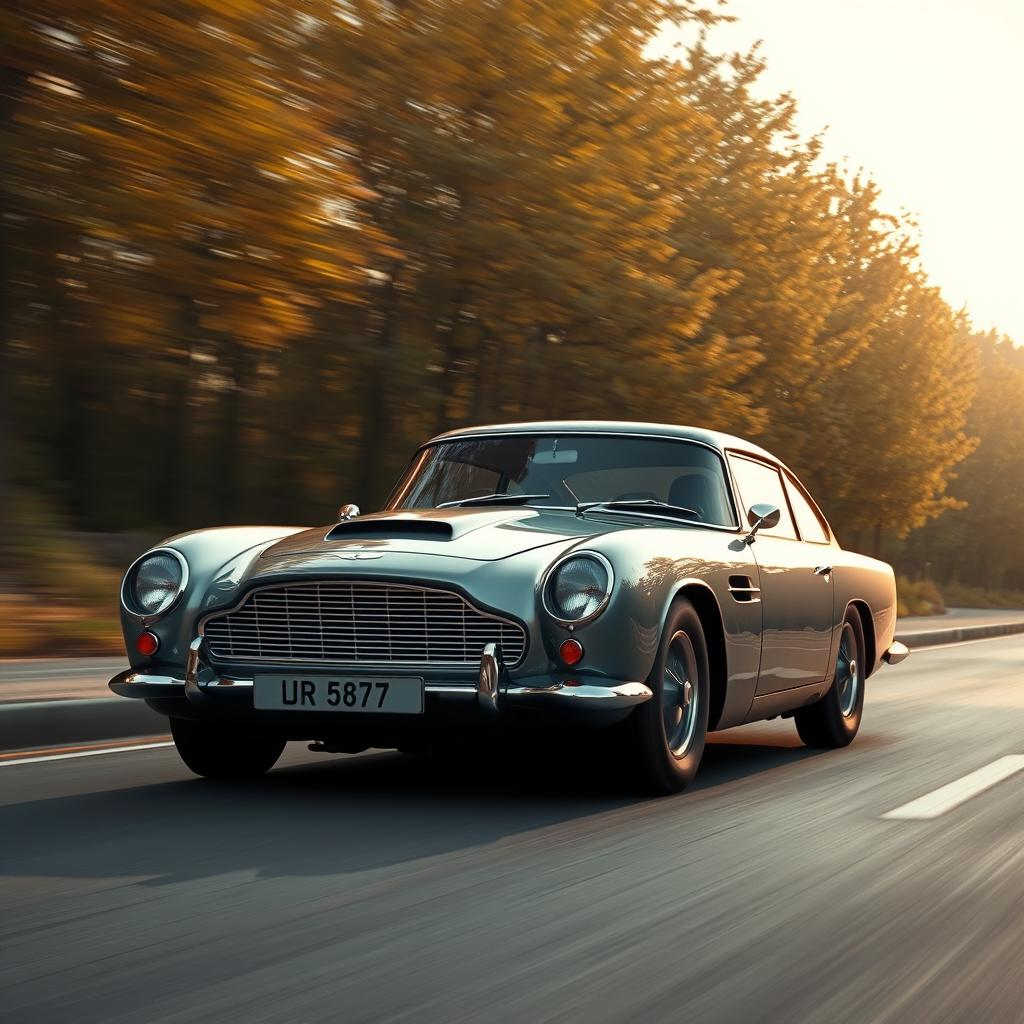

In [3]:
from smolagents import load_tool, CodeAgent, HfApiModel, DuckDuckGoSearchTool

# Import tool from Hub
image_generation_tool = load_tool("m-ric/text-to-image", trust_remote_code=True)


search_tool = DuckDuckGoSearchTool()

model = HfApiModel("Qwen/Qwen2.5-72B-Instruct")
# Initialize the agent with both tools
agent = CodeAgent(
    tools=[image_generation_tool, search_tool], model=model
)

# Run it!
result = agent.run(
    "Generate me a photo of the car that James bond drove in the latest movie.",
)
result

![Image of an Aston Martin DB5](https://huggingface.co/datasets/huggingface/cookbook-images/resolve/main/agents_db5.png)

## 2. 📚💬 RAG with Iterative query refinement & Source selection

Quick definition: Retrieval-Augmented-Generation (RAG) is ___“using an LLM to answer a user query, but basing the answer on information retrieved from a knowledge base”.___

This method has many advantages over using a vanilla or fine-tuned LLM: to name a few, it allows to ground the answer on true facts and reduce confabulations, it allows to provide the LLM with domain-specific knowledge, and it allows fine-grained control of access to information from the knowledge base.

- Now let’s say we want to perform RAG, but with the additional constraint that some parameters must be dynamically generated. For example, depending on the user query we could want to restrict the search to specific subsets of the knowledge base, or we could want to adjust the number of documents retrieved. The difficulty is: **how to dynamically adjust these parameters based on the user query?**

- A frequent failure case of RAG is when the retrieval based on the user query does not return any relevant supporting documents. **Is there a way to iterate by re-calling the retriever with a modified query in case the previous results were not relevant?**


🔧 Well, we can solve the points above in a simple way: we will **give our agent control over the retriever's parameters!**

➡️ Let's show how to do this. We first load a knowledge base on which we want to perform RAG: this dataset is a compilation of the documentation pages for many `huggingface` packages, stored as markdown.


In [4]:
import datasets

knowledge_base = datasets.load_dataset("m-ric/huggingface_doc", split="train")

Now we prepare the knowledge base by processing the dataset and storing it into a vector database to be used by the retriever. We are going to use LangChain, since it features excellent utilities for vector databases:


In [4]:
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings

source_docs = [
    Document(page_content=doc["text"], metadata={"source": doc["source"].split("/")[1]})
    for doc in knowledge_base
]

docs_processed = RecursiveCharacterTextSplitter(chunk_size=500).split_documents(
    source_docs
)[:1000]

embedding_model = HuggingFaceEmbeddings(model_name="thenlper/gte-small")
vectordb = FAISS.from_documents(documents=docs_processed, embedding=embedding_model)

/var/folders/6m/9b1tts6d5w960j80wbw9tx3m0000gn/T/ipykernel_16932/1458839689.py:15: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name="thenlper/gte-small")


Now that we have the database ready, let’s build a RAG system that answers user queries based on it!

We want our system to select only from the most relevant sources of information, depending on the query.

Our documentation pages come from the following sources:

In [5]:
all_sources = list(set([doc.metadata["source"] for doc in docs_processed]))
print(all_sources)

['datasets-server', 'datasets', 'optimum', 'gradio', 'blog', 'course', 'hub-docs', 'pytorch-image-models', 'peft', 'evaluate', 'diffusers', 'hf-endpoints-documentation', 'deep-rl-class', 'transformers']


👉 Now let's build a `RetrieverTool` that our agent can leverage to retrieve information from the knowledge base.

Since we need to add a vectordb as an attribute of the tool, we cannot simply use the [simple tool constructor](https://huggingface.co/docs/transformers/main/en/agents#create-a-new-tool) with a `@tool` decorator: so we will follow the advanced setup highlighted in the [advanced agents documentation](https://huggingface.co/docs/transformers/main/en/agents_advanced#directly-define-a-tool-by-subclassing-tool-and-share-it-to-the-hub).

In [13]:
import json
from smolagents import Tool
from langchain_core.vectorstores import VectorStore


class RetrieverTool(Tool):
    name = "retriever"
    description = "Retrieves some documents from the knowledge base that have the closest embeddings to the input query."
    inputs = {
        "query": {
            "type": "string",
            "description": "The query to perform. This should be semantically close to your target documents. Use the affirmative form rather than a question.",
        },
        "source": {"type": "string", "description": ""},
        "number_of_documents": {
            "type": "string",
            "description": "the number of documents to retrieve. Stay under 10 to avoid drowning in docs",
        },
    }
    output_type = "string"

    def __init__(self, vectordb: VectorStore, all_sources: str, **kwargs):
        super().__init__(**kwargs)
        self.vectordb = vectordb
        self.inputs["source"]["description"] = (
            f"The source of the documents to search, as a str representation of a list. Possible values in the list are: {all_sources}. If this argument is not provided, all sources will be searched.".replace(
                "'", "`"
            )
        )

    def forward(self, query: str, source: str = None, number_of_documents=7) -> str:
        assert isinstance(query, str), "Your search query must be a string"
        number_of_documents = int(number_of_documents)

        if source:
            if isinstance(source, str) and "[" not in str(
                source
            ):  # if the source is not representing a list
                source = [source]
            source = json.loads(str(source).replace("'", '"'))

        docs = self.vectordb.similarity_search(
            query,
            filter=({"source": source} if source else None),
            k=number_of_documents,
        )

        if len(docs) == 0:
            return "No documents found with this filtering. Try removing the source filter."
        return "Retrieved documents:\n\n" + "\n===Document===\n".join(
            [doc.page_content for doc in docs]
        )

### Optional: Share your Retriever tool to Hub

To share your tool to the Hub, first copy-paste the code in the RetrieverTool definition cell to a new file named for instance `retriever.py`.

When the tool is loaded from a separate file, you can then push it to the Hub using the code below (make sure to login with a `write` access token)

In [ ]:
share_to_hub = True

if share_to_hub:
    from huggingface_hub import login
    from retriever import RetrieverTool

    login("your_token")

    tool = RetrieverTool(vectordb, all_sources)

    tool.push_to_hub(repo_id="m-ric/retriever-tool")

    # Loading the tool
    from smolagents import load_tool

    retriever_tool = load_tool(
        "m-ric/retriever-tool", vectordb=vectordb, all_sources=all_sources
    )

### Run the agent!

In [ ]:
from smolagents import HfApiModel, ToolCallingAgent

model = HfApiModel("Qwen/Qwen2.5-72B-Instruct")

retriever_tool = RetrieverTool(vectordb=vectordb, all_sources=all_sources)
agent = ToolCallingAgent(tools=[retriever_tool], model=model, verbose=0)

agent_output = agent.run("Please show me a LORA finetuning script")

print("Final output:")
print(agent_output)

What happened here? First, the agent launched the retriever with specific sources in mind (`['transformers', 'blog']`).

But this retrieval did not yield enough results ⇒ no problem! The agent could iterate on previous results, so it just re-ran its retrieval with less restrictive search parameters.
Thus the research was successful!

Note that **using an LLM agent** that calls a retriever as a tool and can dynamically modify the query and other retrieval parameters **is a more general formulation of RAG**, which also covers many RAG improvement techniques like iterative query refinement.

## 3. 💻 Debug Python code
Since the CodeAgent has a built-in Python code interpreter, we can use it to debug our faulty Python script!

In [7]:
from smolagents import CodeAgent

agent = CodeAgent(tools=[], model=HfApiModel("Qwen/Qwen2.5-72B-Instruct"))

code = """
numbers=[0, 1, 2]

for i in range(4):
    print(numbers(i))
"""

final_answer = agent.run(
    "I have some code that creates a bug: please debug it, then run it to make sure it works and return the final code",
    additional_args=dict(code=code)
)

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ I have some code that creates a bug: please debug it, then run it to make sure it works and return the final    │
│ code                                                                                                            │
│ You have been provided with these additional arguments, that you can access using the keys as variables in your │
│ python code:                                                                                                    │
│ {'code': '\nnumbers=[0, 1, 2]\n\nfor i in range(4):\n    print(numbers(i))\n'}.                                 │
│                                                                                                                 │
╰─ HfApiModel - Qwen/Qwen2.5-72B-Instruct ────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 0 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭─ Executing this code: ──────────────────────────────────────────────────────────────────────────────────────────╮
│   1 numbers=[0, 1, 2]                                                                                           │
│   2                                                                                                             │
│   3 for i in range(4):                                                                                          │
│   4     print(numbers[i])                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Code execution failed: 0
1
2
Code execution failed at line 'for i in range(4):
    print(numbers)' because of the following error:
Index 3 out of bounds for list of length 3

[Step 0: Duration 16.39 seconds| Input tokens: 2,059 | Output tokens: 100]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭─ Executing this code: ──────────────────────────────────────────────────────────────────────────────────────────╮
│   1 numbers=[0, 1, 2]                                                                                           │
│   2                                                                                                             │
│   3 for i in range(len(numbers)):                                                                               │
│   4     print(numbers[i])                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Execution logs:
0
1
2

Out: None

[Step 1: Duration 17.45 seconds| Input tokens: 4,370 | Output tokens: 210]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭─ Executing this code: ──────────────────────────────────────────────────────────────────────────────────────────╮
│   1 fixed_code = '''                                                                                            │
│   2 numbers=[0, 1, 2]                                                                                           │
│   3                                                                                                             │
│   4 for i in range(len(numbers)):                                                                               │
│   5     print(numbers[i])                                                                                       │
│   6 '''                                                                                                         │
│   7                                                                                                             │
│   8 final_answer(fixed_code)                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Out - Final answer: 
numbers=[0, 1, 2]

for i in range(len(numbers)):
    print(numbers[i])

[Step 2: Duration 11.55 seconds| Input tokens: 6,885 | Output tokens: 286]

As you can see, the agent tried the given code, gets an error, analyses the error, corrects the code and returns it after veryfing that it works!

And the final code is the corrected code:

In [8]:
print(final_answer)


numbers=[0, 1, 2]

for i in range(len(numbers)):
    print(numbers[i])



## ➡️ Conclusion

The use cases above should give you a glimpse into the possibilities of our Agents framework!

For more advanced usage, read the [documentation](https://huggingface.co/docs/smolagents/index).

All feedback is welcome, it will help us improve the framework! 🚀